# TransUnet: OCTA Image Segmentation with PyTorch

This GitHub repository hosts the implementation of TransUnet, a deep learning model developed in PyTorch for segmenting capillary free zones (CFZ), arteries, and veins in optical coherence tomography angiography (OCTA) images. The model is trained on high-resolution 6x6mm OCTA images, aiming to accurately delineate vascular structures for medical research and diagnosis.

In [1]:
import os
import random
import time
from shutil import copyfile

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM
import torchvision
import torchvision.transforms as T

from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation
from transformers import BeitForSemanticSegmentation

from dataclasses import dataclass
import dataclasses
import timm

from einops import rearrange, repeat
import ml_collections

In [2]:
import copy
import logging
import math

from os.path import join as pjoin
from collections import OrderedDict


from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage

In [3]:
# Predefined transformations for frequent use
Tensor2PILImage = T.ToPILImage()
PILImage2Tensor = T.ToTensor()

In [4]:
# Classes

CLASSES = ['background', 'vCFZ', 'vein', 'aCFZ', 'artery']

num_of_classes = len(CLASSES)

CLASS_COLORS = [(0, 0, 0), (255, 0, 255), (0, 255, 255), (255, 255, 0), (255, 0, 0)]

class_weights = [1, 1, 1, 1, 1]

id2label = {k: v for k, v in enumerate(CLASSES)}
label2id = {v: k for k, v in enumerate(CLASSES)}

In [5]:
# Create a nested directory structure
parent_dir = 'D:\\AV Project\\CFZ-Net' # Please enter the root directory for your project:

Save_folder_name = "CFZ_Segementation_TransUnet_V01T01"
save_path = os.path.join(parent_dir, Save_folder_name)

dataframe_name = 'train_data_tmp_Idea61CFZ.csv'

project_path = os.path.join(parent_dir, 'tmp_Idea61CFZ')
dataset_path = os.path.join(project_path, 'Dataset')
train_path = os.path.join(dataset_path, 'train')
input_path = os.path.join(train_path, 'Input')
output_path = os.path.join(train_path, 'CFZ_map')


try:
    os.mkdir(save_path)
    os.mkdir(project_path)
    os.mkdir(dataset_path)
    os.mkdir(train_path)
    os.mkdir(input_path)
    os.mkdir(output_path)
except OSError:
    pass

In [6]:
# Create a nested directory structure
parent_dir = 'D:\\AV Project\\CFZ-Net'  # Specify the root directory for the project

dataframe_name = 'train_data_tmp_Idea61CFZ_V16.csv'

project_path = os.path.join(parent_dir, 'tmp_Idea61CFZ_V16')
dataset_path = os.path.join(project_path, 'Dataset')
train_path = os.path.join(dataset_path, 'train')
input_path = os.path.join(train_path, 'Input')
output_path = os.path.join(train_path, 'CFZ_map')



try:
    os.mkdir(project_path)
    os.mkdir(dataset_path)
    os.mkdir(train_path)
    os.mkdir(input_path)
    os.mkdir(output_path)
except OSError:
    pass

In [7]:
imagesize = 320 # Set the standard image size for resizing images
# imagesize = 384 # Set the standard image size for resizing images

def Tranfer_data(SOURCE, DESTINATION):
    """Transfers and processes image files."""
    files = []
    for subfolder in os.listdir(SOURCE):
        if subfolder == 'NPDR_Mild':
            itnum = 6
        else:
            itnum = 1
        for ite in range(itnum):
            for filename in os.listdir(os.path.join(SOURCE, subfolder, 'AVA_map')):
                if filename[-11:] == '_CFZ_MM.png':
                    file_OCTA = os.path.join(SOURCE, subfolder, 'OCTA', filename[:-11] + '.tiff')
                    if not os.path.isfile(file_OCTA):
                        file_OCTA = os.path.join(SOURCE, subfolder, 'OCTA', filename[:-11] + '.png')
                    file_CFZ_map = os.path.join(SOURCE, subfolder, 'AVA_map', filename)

                    # Define the destination paths
                    destination_Input = os.path.join(DESTINATION, 'train/Input', filename[:-5] + '_' + str(ite) +'.png')
                    destination_Output = os.path.join(DESTINATION, 'train/CFZ_map', filename[:-5] + '_' + str(ite) + '.png')

                    # Read and resize the OCTA and CFZ map images
                    im_OCTA = cv2.imread(file_OCTA, cv2.IMREAD_GRAYSCALE)
                    im_CFZ_map = cv2.imread(file_CFZ_map)
                    im_OCTA = cv2.resize(im_OCTA, (imagesize, imagesize))
                    im_CFZ_map = cv2.resize(im_CFZ_map, (imagesize, imagesize))

                    # Normalize OCTA images to 0-255 scale
                    im_OCTA = np.array(im_OCTA, dtype=np.float32)
                    im_CFZ_map = np.array(im_CFZ_map, dtype=np.float32)
                    im_OCTA = 255.0 * (im_OCTA - np.min(im_OCTA)) / (np.max(im_OCTA) - np.min(im_OCTA))

                    # Convert grayscale image to 3-channel
                    im_OCTA_3chs = cv2.merge([im_OCTA, im_OCTA, im_OCTA])

                    # Save the processed images
                    cv2.imwrite(destination_Input, im_OCTA_3chs.astype(np.uint8))
                    cv2.imwrite(destination_Output, im_CFZ_map.astype(np.uint8))

                    files.append(filename[:-5] + '_' + str(ite) +'.png')

    files = list(set(files))
    return files


SOURCE_DIR = "D:\\AV Project\\Dataset6x6mm\\"
DESTINATION_DIR = dataset_path


# filenames = Tranfer_data(SOURCE_DIR, DESTINATION_DIR)

In [8]:
# # Create the DataFrame and save to CSV
# dframe1 = pd.DataFrame({'Input' : filenames, 'CFZ' : filenames})
# dframe1.to_csv(os.path.join(parent_dir, dataframe_name), index=False)
# dframe1.head()

In [9]:
def get_device():
    """Return the appropriate device (CUDA or CPU) based on availability."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_device(x):
    """Send the tensor or model to the appropriate device."""
    device = get_device()
    return x.to(device)


def get_model_parameters(model):
    return sum(param.numel() for param in model.parameters())


print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [10]:
def set_class_values(all_classes, classes_to_train):
    """Assigns a specific class label to each of the classes."""

    class_indices = {cls.lower(): idx for idx, cls in enumerate(all_classes)}
    class_values = [class_indices[cls.lower()] for cls in classes_to_train]

    return class_values


def get_label_mask(mask, class_values, label_colors_list):
    """Encodes image pixels into class-specific labels."""

    mask = np.array(mask)
    label_colors = np.array(label_colors_list)

    # Initializing the label mask
    label_mask = np.zeros((mask.shape[0], mask.shape[1], 1), dtype=int)

    # Iterate over each class and update the label mask
    for value, color in enumerate(label_colors):
        if value in class_values:
            # Compare mask with class color and update label_mask
            matches = np.all(mask == color, axis=-1)
            label_mask[matches] = value

    return label_mask


def load_image_paths(df, path, column):
    """Lists image paths."""
    images = []
    for i, item in df.iterrows():
        temp_item =  os.path.join(path , item[column])
        images.append(temp_item)
    return images



def get_images(parent_dir, fold_num = 1, max_fold = 5):
    """Loads paths for training and validation images and masks based on the fold."""
    # Define paths
    train_csv_path = os.path.join(parent_dir, dataframe_name)
    image_dir = input_path
    mask_dir = output_path

    # Read the data CSV
    df = pd.read_csv(train_csv_path)

    # Calculate the indices for training and validation splits
    num_samples = len(df)
    start_val = int((fold_num - 1) / max_fold * num_samples)
    end_val = int(fold_num / max_fold * num_samples)

    # Create training and validation subsets
    df_train = pd.concat([df[:start_val], df[end_val:]], ignore_index=True)
    df_val = df[start_val:end_val]

    # Load image and mask paths
    train_images = load_image_paths(df_train, image_dir, 0)
    train_masks = load_image_paths(df_train, mask_dir, 1)
    valid_images = load_image_paths(df_val, image_dir, 0)
    valid_masks = load_image_paths(df_val, mask_dir, 1)

    return train_images, train_masks, valid_images, valid_masks



def train_transforms(img_size):
    """Transforms/augmentations for training images and masks."""
    train_image_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(shear=0.4, mode=4, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, p=1.0),
        A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=50, shift_limit=0.3, p=1.0),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, always_apply=True),
        A.Blur(blur_limit=3, p=0.2),
        A.Resize(img_size, img_size, always_apply=True, p=1.0)
    ])
    return train_image_transform


def valid_transforms(img_size):
    """Transforms/augmentations for validation images and masks."""
    return A.Compose([A.Resize(img_size, img_size, always_apply=True, p=1.0)])


class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, tfms, label_colors_list, classes_to_train, all_classes):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.tfms = tfms
        self.label_colors_list = label_colors_list
        self.all_classes = all_classes
        self.classes_to_train = classes_to_train
        # Convert string names to class values for masks.
        self.class_values = set_class_values(
            self.all_classes, self.classes_to_train
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load the image and mask
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float32')
        image = image / 255.0
        mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB).astype('float32')

        # Apply transformations
        transformed = self.tfms(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

        # Get colored label mask.
        mask = get_label_mask(mask, self.class_values, self.label_colors_list)

        # Convert to tensors
        image = torch.from_numpy(np.transpose(image, (2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(mask, (2, 0, 1))).long()

        return image, mask

In [11]:
# Define constants for training
classes_to_train = CLASSES
batch_size = 15
fold_num = 5
max_fold = 5

# Load images and masks
train_images, train_masks, valid_images, valid_masks = get_images(parent_dir, fold_num = fold_num, max_fold = 5)

# Set up transformations
train_tfms = train_transforms(imagesize)
valid_tfms = valid_transforms(imagesize)

# Initialize datasets
train_dataset = SegmentationDataset(train_images, train_masks, train_tfms,
    CLASS_COLORS, classes_to_train, CLASSES)
valid_dataset = SegmentationDataset(valid_images, valid_masks, valid_tfms,
    CLASS_COLORS, classes_to_train, CLASSES)

# Configure data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False)

# Access a batch of data
(train_data_inputs, train_data_targets) = next(iter(train_data_loader))
(valid_data_inputs, valid_data_targets) = next(iter(valid_data_loader))
print(train_data_inputs.shape, train_data_targets.shape, train_data_inputs.dtype, train_data_targets.dtype)
print(valid_data_inputs.shape, valid_data_targets.shape, valid_data_inputs.dtype, valid_data_targets.dtype)

torch.Size([15, 3, 320, 320]) torch.Size([15, 1, 320, 320]) torch.float32 torch.int64
torch.Size([15, 3, 320, 320]) torch.Size([15, 1, 320, 320]) torch.float32 torch.int64


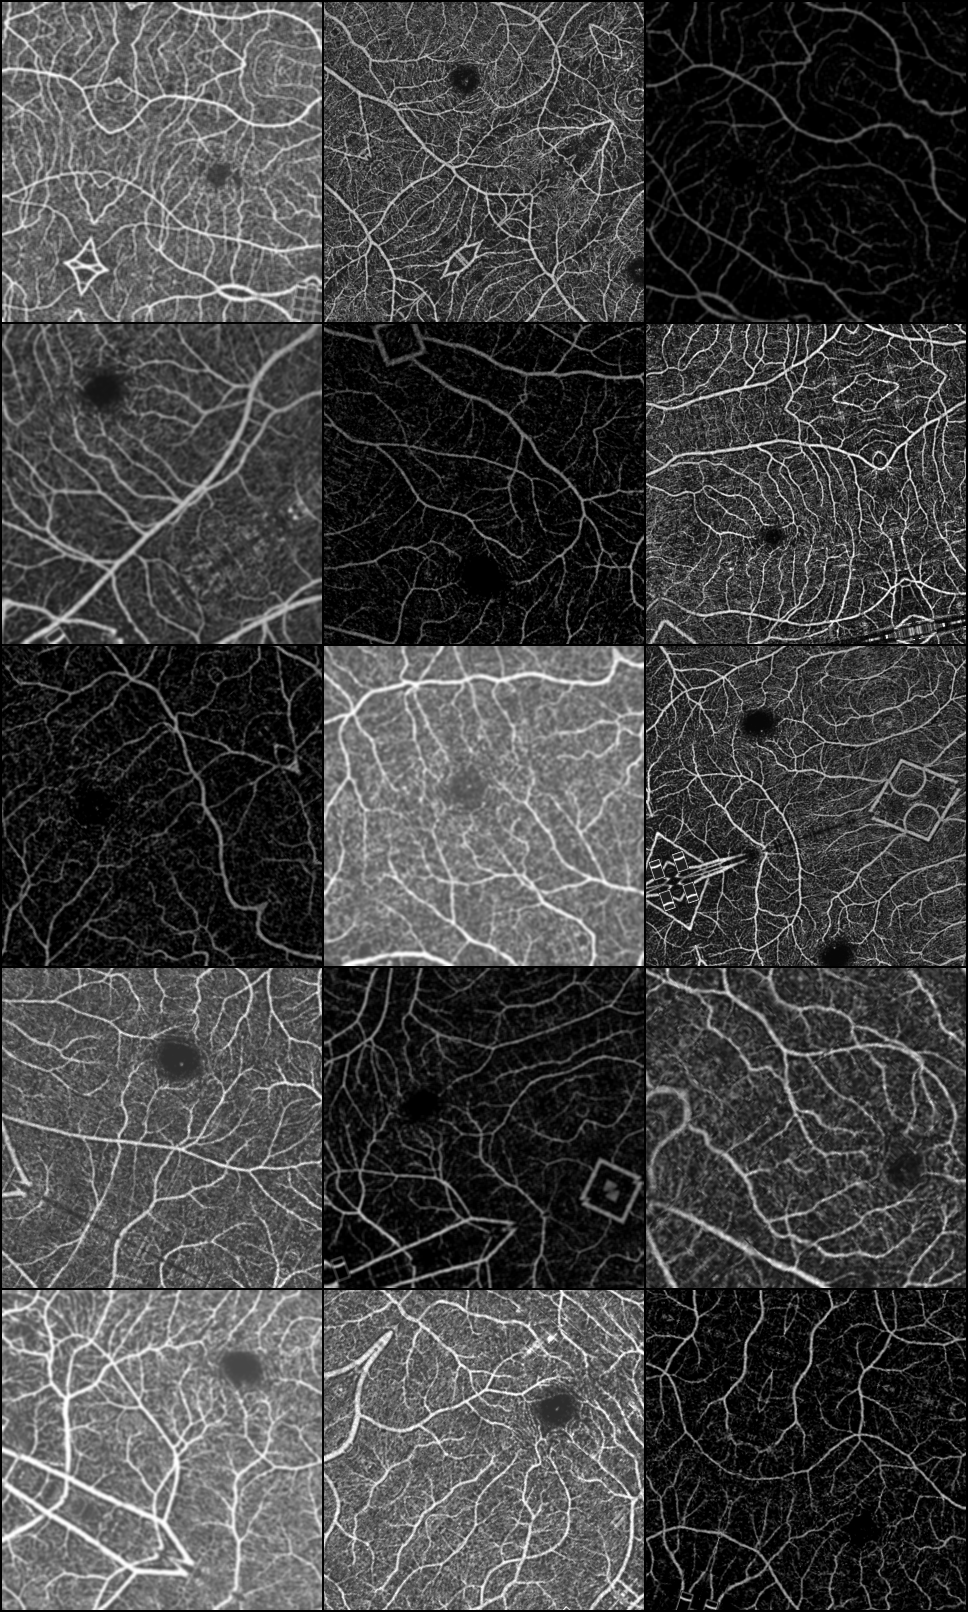

In [12]:
# Create a grid of input images
data_input_grid = torchvision.utils.make_grid(train_data_inputs, nrow=3)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_input_grid)

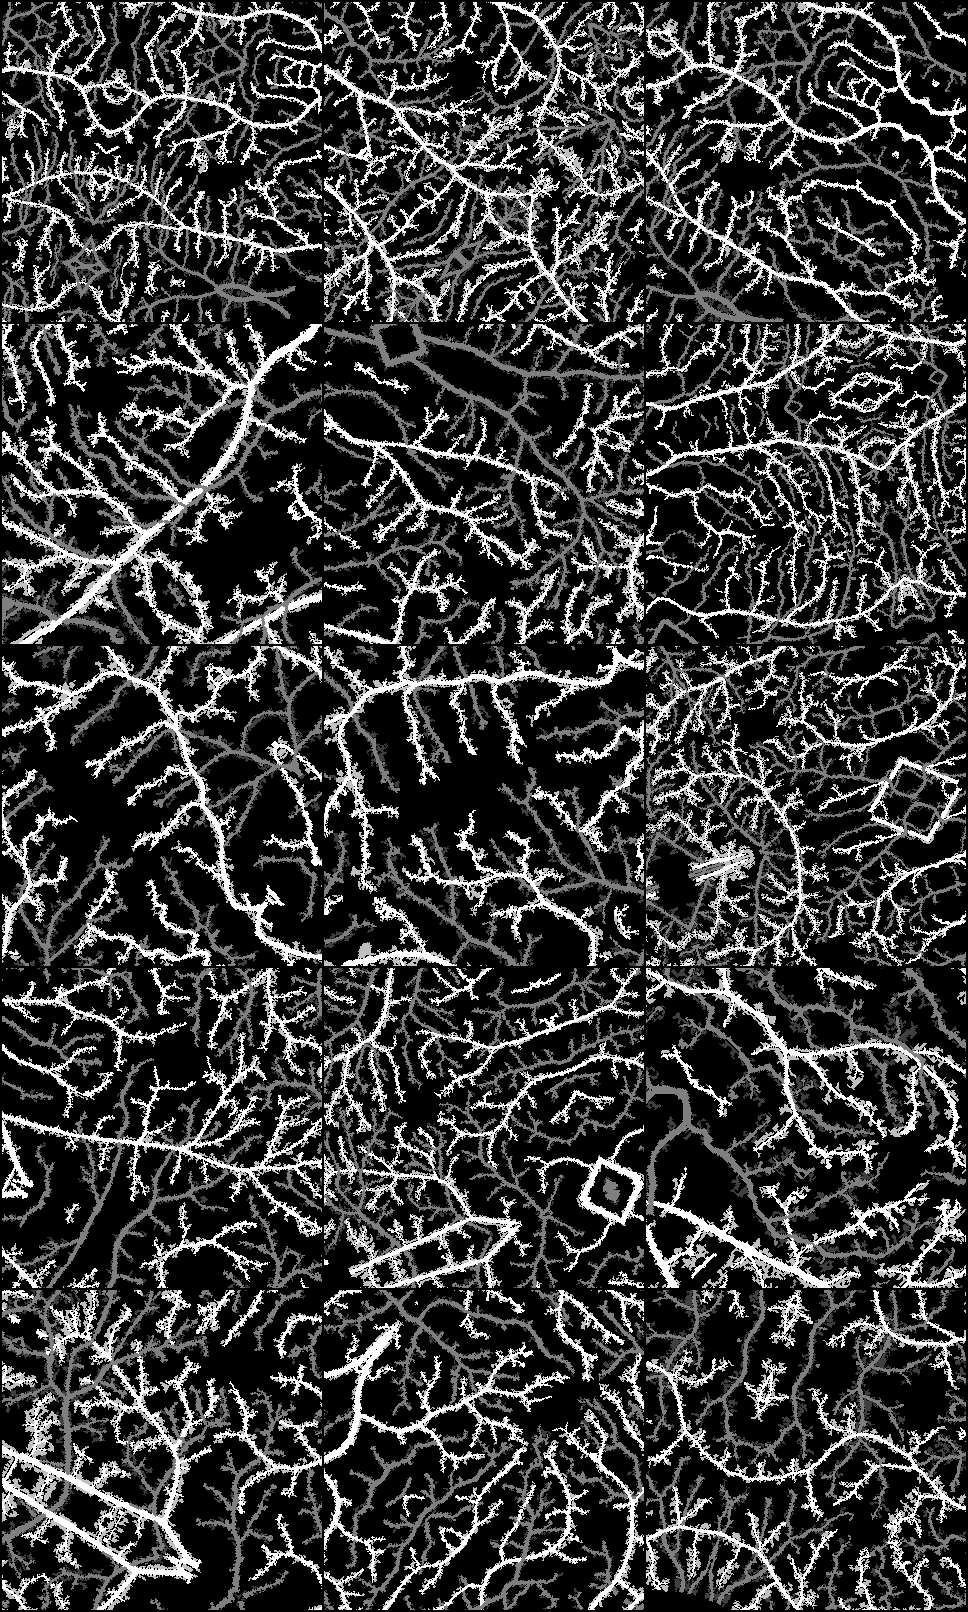

In [13]:
# Create a grid of output images
data_targets_grid = torchvision.utils.make_grid(train_data_targets / 4.0, nrow=3)
# Convert the tensor to a PIL Image
Tensor2PILImage(data_targets_grid)

In [14]:
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 2
    config.activation = 'softmax'
    return config


def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 2
    config.n_skip = 3
    config.activation = 'softmax'

    return config

In [15]:

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

class ResNetV2(nn.Module):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(3, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]

In [16]:
logger = logging.getLogger(__name__)


ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)

        if config.patches.get("grid") is not None:   # ResNet
            grid_size = config.patches["grid"]
            patch_size = (img_size[0] // 16 // grid_size[0], img_size[1] // 16 // grid_size[1])
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])
            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features


class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            query_weight = np2th(weights[pjoin(ROOT, ATTENTION_Q, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))


class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights


class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features


class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)


class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3-i]=0

        else:
            skip_channels=[0,0,0,0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=21843, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        if x.size()[1] == 1:
            x = x.repeat(1,3,1,1)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits

    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)

CONFIGS = {
    'R50-ViT-B_16': get_r50_b16_config(),
}

In [17]:
config_vit = CONFIGS['R50-ViT-B_16']
vit_patches_size = 16
config_vit.n_classes = 5
config_vit.n_skip = 3
config_vit.patches.grid = (int(imagesize / vit_patches_size), int(imagesize / vit_patches_size))
config_vit

activation: softmax
classifier: seg
decoder_channels: !!python/tuple
- 256
- 128
- 64
- 16
hidden_size: 768
n_classes: 5
n_skip: 3
patch_size: 16
patches:
  grid: !!python/tuple
  - 20
  - 20
  size: !!python/tuple
  - 16
  - 16
pretrained_path: ../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz
representation_size: null
resnet:
  num_layers: !!python/tuple
  - 3
  - 4
  - 9
  width_factor: 1
resnet_pretrained_path: null
skip_channels:
- 512
- 256
- 64
- 16
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [18]:
# Initialize the model and move it to the defined device
model = VisionTransformer(config_vit, img_size=imagesize, num_classes=config_vit.n_classes)
to_device(model)

# Perform a forward pass and check the output shape
print(model(to_device(train_data_inputs)).shape)

torch.Size([15, 5, 320, 320])


In [19]:
model.load_from(weights=np.load('D:\\AV Project\\CFZ-Net\\CFZ segementation V13T01\\imagenet21k_R50+ViT-B_16.npz'))

load_pretrained: grid-size from 14 to 20


In [20]:
def IoUMetric(pred, gt, num_of_classes, weights=None, softmax=False):
    """Calculate the weighted mean Intersection over Union (IoU)."""
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # One-hot encoding of ground truth
    gt = F.one_hot(gt.squeeze(1), num_classes=num_of_classes).permute(0, 3, 1, 2).float()

    # Computation of intersection and union
    intersection = torch.sum(gt * pred, dim=(2, 3))
    union = torch.sum(pred + gt, dim=(2, 3)) - intersection

    # Apply weights
    if weights is not None:
        intersection = weights * intersection
        union = weights * union


    # Compute IoU avoiding division by zero
    valid = union > 0
    iou = torch.zeros_like(union)
    iou[valid] = intersection[valid] / union[valid]

    # Mean IoU across all valid entries
    return iou[valid].mean()



class IoULoss(nn.Module):
    def __init__(self, num_of_classes, weights=None, softmax=False):
        super().__init__()
        self.softmax = softmax
        self.num_of_classes = num_of_classes
        self.weights = weights

    def forward(self, pred, gt):
        # Convert IoU score to a loss value
        return -torch.log(IoUMetric(pred, gt, self.num_of_classes, self.weights, self.softmax))

In [21]:
def train_model(model, loader, optimizer, use_cel=False):
    """Trains the model using a specified data loader and optimizer."""
    to_device(model.train())

    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs, targets = to_device(inputs), to_device(targets)
        optimizer.zero_grad()
        outputs = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

    return running_loss / running_samples

In [22]:
def calculate_metrics(model, loader, use_cel=False):
    """Calculates different metrics during training."""
    if use_cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True, num_of_classes=num_of_classes, weights=to_device(torch.tensor(class_weights)))

    to_device(model.eval())
    f1score = to_device(TM.classification.MulticlassF1Score(num_of_classes, average='micro'))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(num_of_classes, average='micro'))

    f1_scores = []
    pixel_accuracies = []
    iou_accuracies = []
    running_loss = 0.0
    running_samples = 0

    for inputs, targets in loader:
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        if use_cel:
            targets = targets.squeeze(dim=1)

        loss = criterion(predictions, targets)
        running_samples += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        f1_score = f1score(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        iou = IoUMetric(pred_probabilities, targets, num_of_classes=num_of_classes)

        f1_scores.append(f1_score.item())
        pixel_accuracies.append(pixel_accuracy.item())
        iou_accuracies.append(iou.item())

    f1_score_tensor = torch.FloatTensor(f1_scores)
    accuracy_tensor = torch.FloatTensor(pixel_accuracies)
    iou_tensor = torch.FloatTensor(iou_accuracies)

    return running_loss/running_samples, accuracy_tensor.mean().item(), iou_tensor.mean().item(), f1_score_tensor.mean().item()

In [23]:
def plot_metric(x, y, xlabel, ylabel, title, save_path, filename):
    """Helper function to plot and save a metric."""
    plt.figure(figsize=(10, 7), facecolor='white')
    plt.plot(x, color='tab:blue', linestyle='-', label=f'train {ylabel}')
    plt.plot(y, color='tab:red', linestyle='-', label=f'validation {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(os.path.join(save_path, filename))


def learning_plots(train_acc, val_acc, train_loss, val_loss, train_iou, valid_iou, save_path):
    """Function to save the loss, accuracy, and IoU plots to disk."""

    plot_metric(train_acc, val_acc, 'Epochs', 'accuracy', 'Training vs Validation Accuracy', save_path, 'accuracy.png')

    plot_metric(train_loss, val_loss, 'Epochs', 'loss', 'Training vs Validation Loss', save_path, 'loss.png')

    plot_metric(train_iou, valid_iou, 'Epochs', 'IoU', 'Training vs Validation mIoU', save_path, 'iou.png')


In [24]:
def train_loop(model, train_loader, valid_loader, epochs, optimizer, scheduler, save_path, use_cel = False):
    """Trains the model over specified epochs, evaluates performance metrics, and saves the trained model."""

    train_loss_list, train_acc_list, train_iou_list, train_f1_list = [], [], [], []
    val_loss_list, val_acc_list, val_iou_list, val_f1_list = [], [], [], []
    for epoch in range(1, epochs + 1):
        loss = train_model(model, train_loader, optimizer, use_cel=use_cel)
        with torch.inference_mode():
            train_loss, train_acc, train_iou, train_f1 = calculate_metrics(model, train_loader, use_cel=use_cel)
            val_loss, val_acc, val_iou, val_f1 = calculate_metrics(model, valid_loader, use_cel=use_cel)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        train_iou_list.append(train_iou)
        train_f1_list.append(train_f1)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        val_iou_list.append(val_iou)
        val_f1_list.append(val_f1)


        print(f"Epoch: {epoch:04d}, LR: {optimizer.param_groups[0]['lr']:.5f}, Training: (Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}, IoU: {train_iou:.4f}), " +
        f"Valication: (Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, IoU: {val_iou:.4f})")

        if scheduler is not None:
            scheduler.step()


    torch.save(model.state_dict(), os.path.join(save_path, f"Trained_model.pth"))
    learning_plots(train_acc_list, val_acc_list, train_loss_list, val_loss_list, train_iou_list, val_iou_list, save_path)


Epoch: 0001, LR: 0.00100, Training: (Loss: 2.1945, Acc: 0.6363, F1: 0.6363, IoU: 0.1113), Valication: (Loss: 2.2003, Acc: 0.6392, F1: 0.6392, IoU: 0.1108)
Epoch: 0002, LR: 0.00100, Training: (Loss: 1.8959, Acc: 0.6300, F1: 0.6300, IoU: 0.1504), Valication: (Loss: 1.8921, Acc: 0.6344, F1: 0.6344, IoU: 0.1508)
Epoch: 0003, LR: 0.00100, Training: (Loss: 1.7047, Acc: 0.6277, F1: 0.6277, IoU: 0.1815), Valication: (Loss: 1.6901, Acc: 0.6365, F1: 0.6365, IoU: 0.1846)
Epoch: 0004, LR: 0.00100, Training: (Loss: 1.5681, Acc: 0.6339, F1: 0.6339, IoU: 0.2094), Valication: (Loss: 1.5505, Acc: 0.6364, F1: 0.6364, IoU: 0.2122)
Epoch: 0005, LR: 0.00100, Training: (Loss: 1.5161, Acc: 0.6821, F1: 0.6821, IoU: 0.2202), Valication: (Loss: 1.4961, Acc: 0.6925, F1: 0.6925, IoU: 0.2240)
Epoch: 0006, LR: 0.00100, Training: (Loss: 1.4703, Acc: 0.6818, F1: 0.6818, IoU: 0.2295), Valication: (Loss: 1.4653, Acc: 0.6852, F1: 0.6852, IoU: 0.2310)
Epoch: 0007, LR: 0.00100, Training: (Loss: 1.4155, Acc: 0.6817, F1: 0.

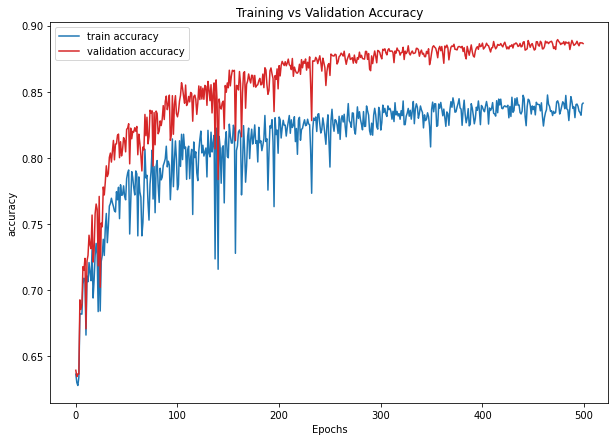

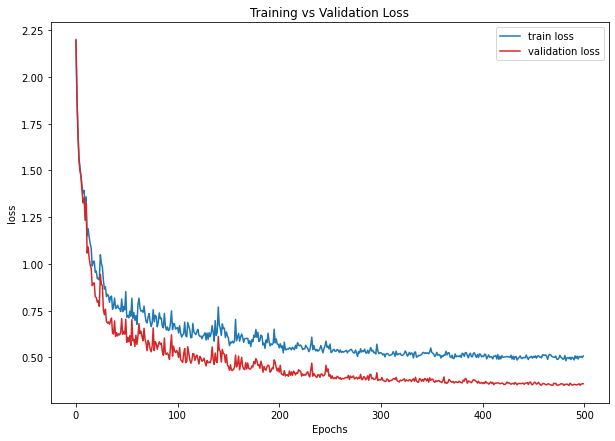

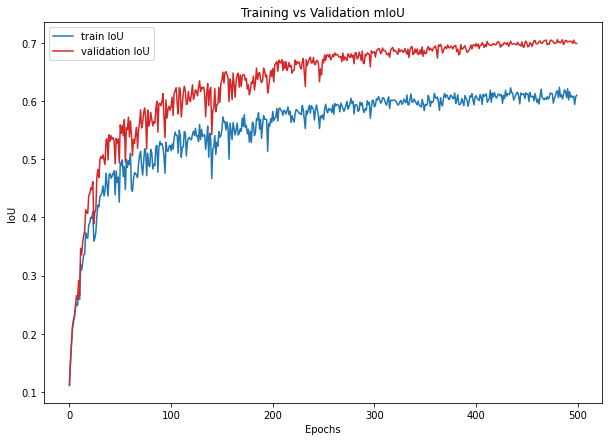

In [25]:
# Set random seeds and make CUDA operations deterministic for reproducible results across multiple runs
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


# Optimizer and Learning Rate Scheduler.
to_device(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
epochs = 500

train_loop(model, train_data_loader, valid_data_loader, epochs, optimizer, scheduler, save_path)

In [27]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(5, average='micro'))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(5, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets, num_of_classes=num_of_classes)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

In [28]:
# Let's test the accuracy of both models on the test dataset.
with torch.inference_mode():
    # Accuracy of the model with ~15M parameters.
    test_dataset_accuracy(model, valid_data_loader)

Test Dataset Accuracy
Pixel Accuracy: 0.8864, IoU Accuracy: 0.7959, Custom IoU Accuracy: 0.6991


In [29]:
def inv_segmentation_map(outputs):
    """Converts model output tensors into a segmentation map."""
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    class_colors = np.array(CLASS_COLORS)

    # Create the segmentation map by indexing directly into class_colors
    segmentation_map = class_colors[labels]

    return segmentation_map

def make_predictions(filename, INPUT_DIR, OUTPUT_DIR):
    """Processes OCTA images to predict segmentation maps, evaluate model performance metrics, and visualize the results."""
    file_OCTA = os.path.join(INPUT_DIR, filename)
    file_CFZ_map = os.path.join(OUTPUT_DIR, filename)
    im_OCTA = Image.open(file_OCTA)
    im_CFZ_map = Image.open(file_CFZ_map)
    im_CFZ_inv = im_CFZ_map
    im_OCTA = PILImage2Tensor(im_OCTA)
    im_OCTA = im_OCTA.unsqueeze(0)
    im_CFZ_map = np.array(im_CFZ_map)

    class_values = set_class_values(CLASSES, CLASSES)
    im_CFZ_map = get_label_mask(im_CFZ_map, class_values, CLASS_COLORS)
    im_CFZ_map = torch.nn.functional.one_hot(torch.tensor(im_CFZ_map, dtype=torch.long)).permute(2, 3, 0, 1)

    # Model predictions and evaluations
    pred = model(to_device(im_OCTA))
    impred = nn.Softmax(dim=1)(pred)

    tp, fp, fn, tn = smp.metrics.get_stats(impred, to_device(im_CFZ_map), mode='multilabel', threshold=0.5)
    iou_score_smp = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro").item()
    iou_score_smp_N = smp.metrics.iou_score(tp, fp, fn, tn, reduction=None)
    f1_score_smp = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()
    accuracy_smp_N = smp.metrics.accuracy(tp, fp, fn, tn, reduction=None)

    iou_perclass_smp = iou_score_smp_N.tolist()[0]
    accuracy_perclass_smp = accuracy_smp_N.tolist()[0]

    impredinv = inv_segmentation_map(impred)

    plt.figure(figsize=(35, 35)).patch.set_facecolor('white')
    display_list = [Tensor2PILImage(im_OCTA.squeeze()), im_CFZ_inv, impredinv]
    titles=['OCTA', 'Ground Truth', 'Predicted\nAcc= '+str(np.around(accuracy_smp,4))+', meanIOU= '+str(np.around(iou_score_smp,4))+', IOU coef per class = '+str(np.around(iou_perclass_smp,4))]
    cmaps = ['gray', 'viridis', 'viridis']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        img_arr = display_list[i]
        plt.imshow(img_arr, cmap=cmaps[i], vmin=0, vmax=255)

    return impred

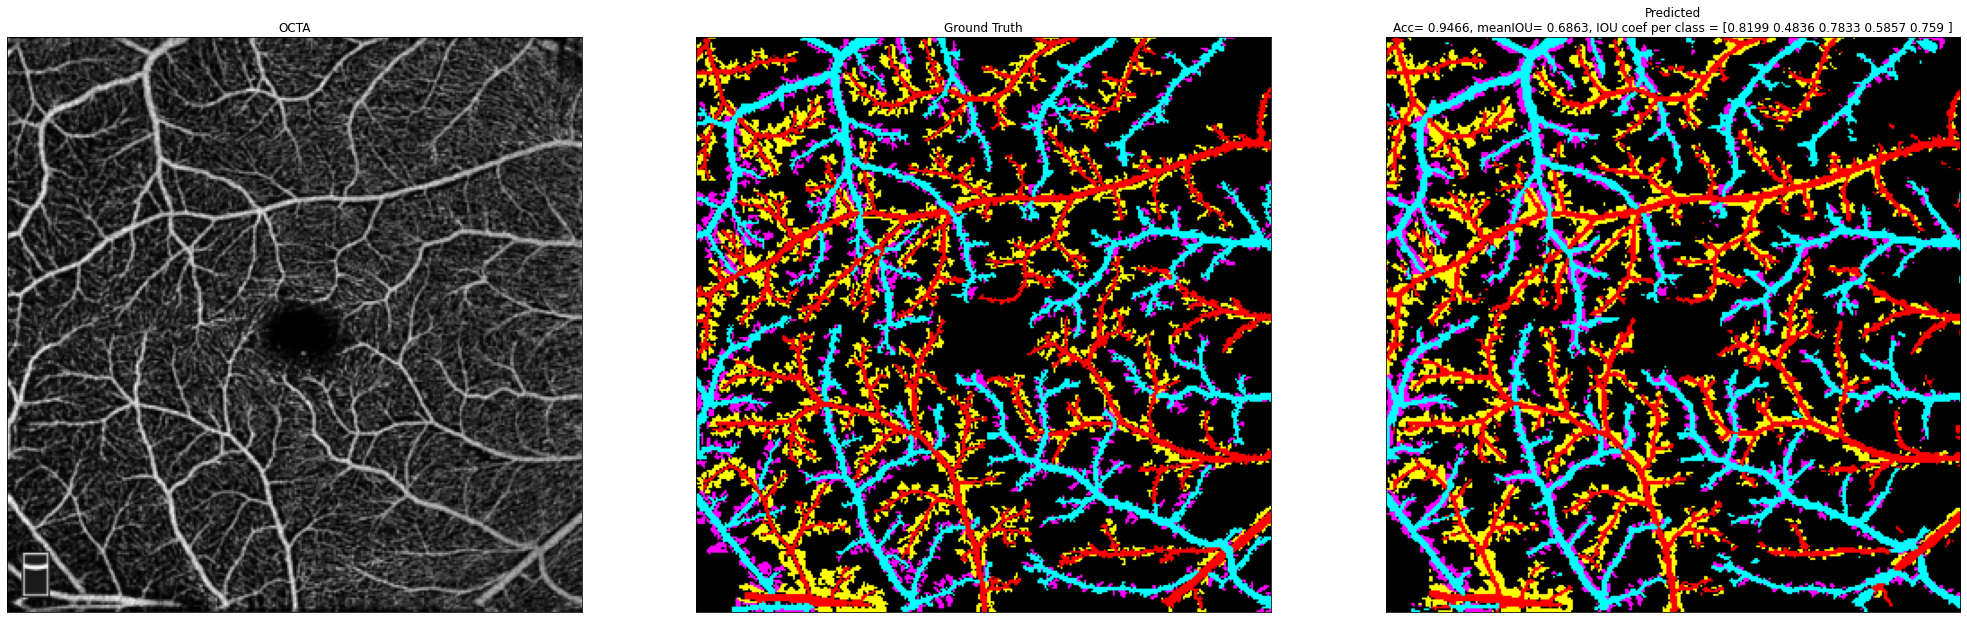

In [30]:
# Sample fron training dataset
filename = random.sample(train_images, 1)[0].split('\\')[-1]

INPUT_DIR = input_path
OUTPUT_DIR = output_path

impred = make_predictions(filename, INPUT_DIR, OUTPUT_DIR)

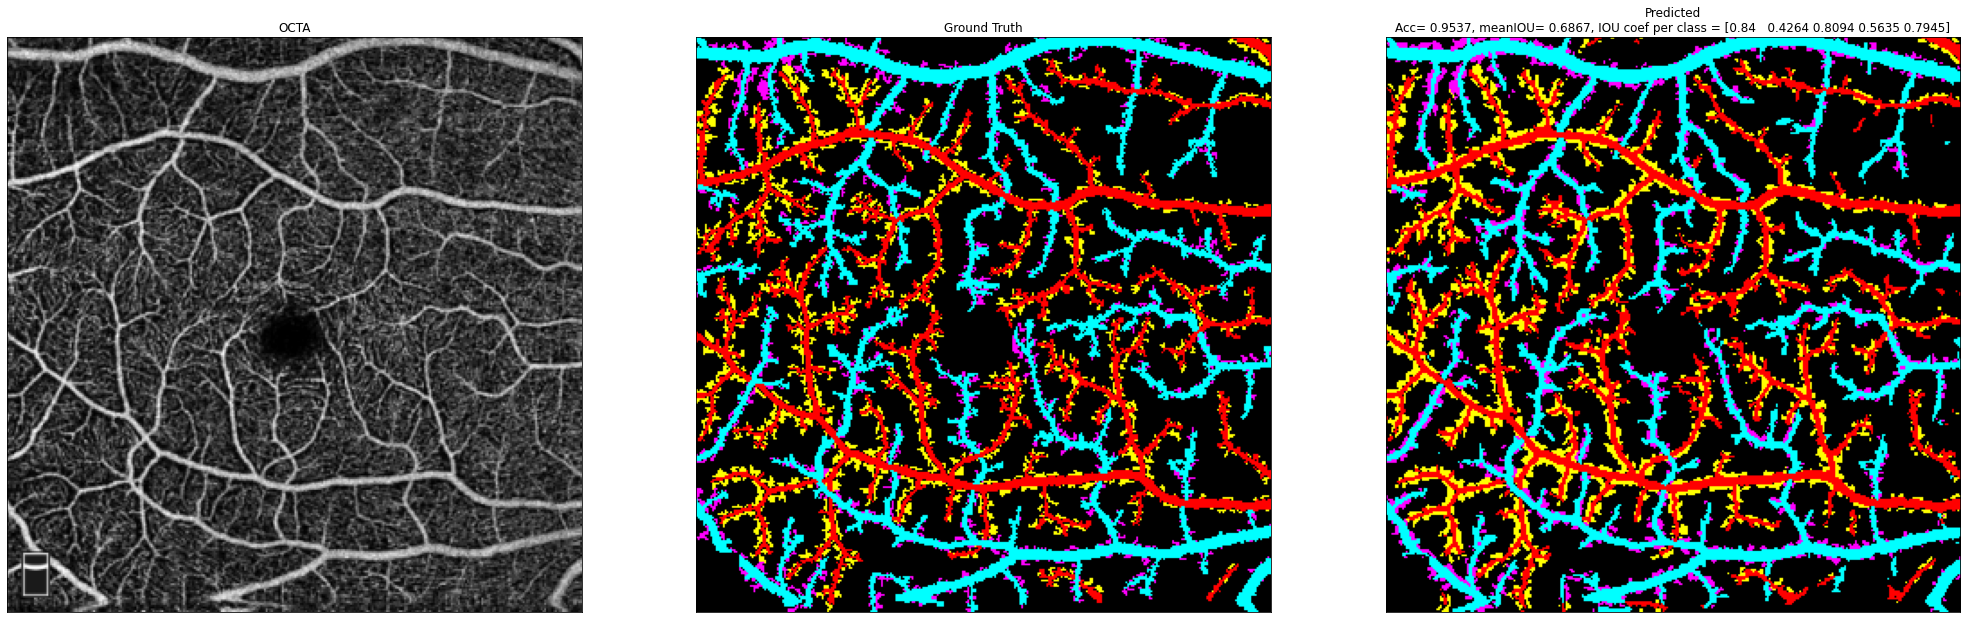

In [32]:
# Sample fron validation dataset
filename = random.sample(valid_images, 1)[0].split('\\')[-1]

INPUT_DIR = input_path
OUTPUT_DIR = output_path

impred = make_predictions(filename, INPUT_DIR, OUTPUT_DIR)